<a href="https://colab.research.google.com/github/marcellosicbaldi/SincNet-Tensorflow/blob/main/SincNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
from scipy import signal
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, SeparableConv2D, DepthwiseConv2D, BatchNormalization, SpatialDropout2D, Layer
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.callbacks import LambdaCallback

### Implementing band-pass filters

In the time domain, a low-pass filter is defined as:

\begin{align}
         h[n] = 2f_csinc(2f_cn)
\end{align}

where $f_c$ is the cutoff frequency specified as a fraction of the sampling rate $f_s$, and 

\begin{align}
         sinc(x) = \frac{sin(\pi x)}{\pi x}
\end{align}

The following function implements a low-pass filter given its cutoff frequency, exploiting the symmetry of the sinc.



In [ ]:
def low_pass(fc, t_right):
  y_right = K.sin(math.pi * 2*fc * t_right) / (math.pi * 2*fc * t_right)
  y = K.concatenate((y_right[::-1], K.ones((1,)), y_right)) 
  return 2*fc*y

A band-pass filter can be written as the difference between two low-pass filters: 

\begin{align}
         g[n] = 2f_2sinc(2f_2n) - 2f_1sinc(2f_1n)
\end{align}


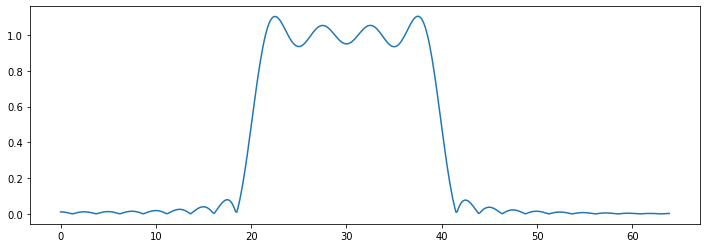

In [ ]:
# Simple example
kernel_size = 51
fs = 128
f1 = 20/fs
f2 = 40/fs
plt.figure(figsize = (12,4))
t_right = K.constant(np.linspace(1, (kernel_size - 1) / 2, int((kernel_size - 1) / 2)))
bp_filter = low_pass(f2, t_right) - low_pass(f1, t_right)
f, H = signal.freqz(bp_filter, fs = 128)
plt.plot(f, np.abs(H));

As we can see from the figure, there is excessive ripples in the passband and poor attenuation in the stopband due to the finite kernel size To counteract this issue we can use windowing, which is performed by multiplying the truncated filter with a window function w. This smooths out the abrupt discontinuities at the end of the filter. Hamming window: 
\begin{align}
w[n] = 0.54 - 0.46cos(\frac{2\pi n}{M})
\end{align}


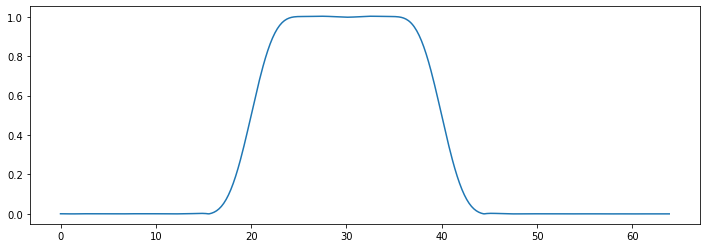

In [ ]:
# Windowing the filter
n = np.linspace(0, kernel_size, kernel_size)
window = K.constant(0.54 - 0.46 * np.cos(2 * math.pi * n / kernel_size))

plt.figure(figsize = (12,4))
f, H = signal.freqz(bp_filter*window, fs = 128)
plt.plot(f, np.abs(H));

The cut-off frequencies $f_1$ and $f_2$ are initialized randomly in the range $[4, 38]$ Hz, making sure $f_1 ≥ 0$ and  $f_1 ≥ f_2$. (Line 18 and 21 next cell)

Putting it all together:

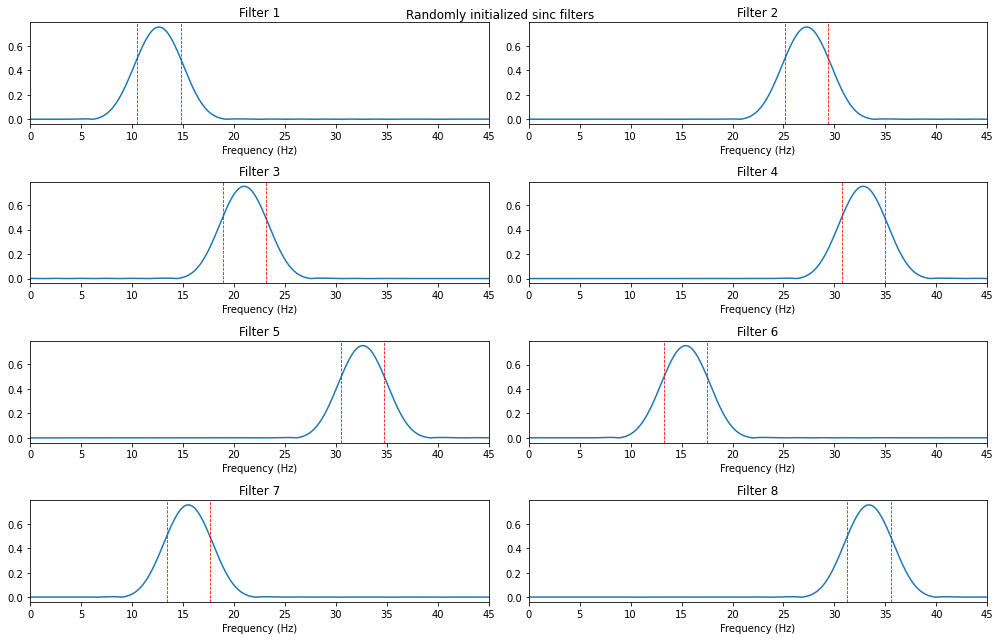

In [ ]:
np.random.seed(seed=1234)
fs = 128
N_filt = 8
kernel_size = 51

low_freq = 4
high_freq = 38

# Random initialization
low_hz = np.random.uniform(low_freq, high_freq, 8)

hz_points = np.linspace(low_freq, high_freq, N_filt+1)
band_hz = np.diff(hz_points)  

filt_b1 = low_hz / fs
filt_band = band_hz / fs 

# lower cutoff frequency
f1 = K.cast(K.abs(filt_b1), 'float32') 

# upper cutoff frequency
f2 = f1 + (K.cast(K.abs(filt_band), 'float32')) 

# window
n = np.linspace(0, kernel_size, kernel_size)
window = K.constant(0.54 - 0.46 * np.cos(2 * math.pi * n / kernel_size))

# right half time of the sinc
t_right = K.constant(np.linspace(1, (kernel_size - 1) / 2, int((kernel_size - 1) / 2)))

plt.figure(figsize=(14,9))
output_list = []
for i in range(N_filt):
    low_pass1 = low_pass(f1[i], t_right)
    low_pass2 = low_pass(f2[i], t_right)
    band_pass = (low_pass2 - low_pass1) * window 
    ax = plt.subplot(4, 2, i+1)
    f, H = signal.freqz(band_pass, fs = 128)
    ax.plot(f, np.abs(H))
    plt.xlabel('Frequency (Hz)')
    plt.xlim([0, 45])
    ax.title.set_text('Filter {}' .format(i+1))
    ax.axvline(f1[i]*fs, c = 'r', ls = '--', lw = 0.8)
    ax.axvline(f2[i]*fs, c = 'r', ls = '--', lw = 0.8)
    output_list.append(band_pass) 

plt.suptitle('Randomly initialized sinc filters');
plt.tight_layout()
plt.show()

In [ ]:
# Getting and reshaping the filters
filters = K.stack(output_list) # (8, 51)
filters = K.transpose(filters) # (51, 8)
filters = K.reshape(filters, (1, kernel_size, 1, N_filt)) # height, width, in_ch, out_ch
filters.shape 

TensorShape([1, 51, 1, 8])


Trying the filters on 1 epoch of EEG data (BCI competition IV 2a)

In [ ]:
fname = '/content/drive/MyDrive/BCI_MI_data/dataset_BCI_IV2a/sub-008.mat'
data = loadmat(fname, struct_as_record = True)
data.keys()

X = data['x_train'].transpose([2,1,0])
x_test = data['x_test'].transpose([2,1,0])
y = data['y_train'].squeeze()
y_test = data['y_test'].squeeze()
channels = data['channels']
fs = data['sf'].squeeze()

X = X*1000 # scale by 1000 due to scaling sensitivity in deep learning
x_test = x_test*1000
n_ex, C, T = X.shape

# Get 1 epoch
x = X[1,:,:] 
xx = x.reshape(1,22,256,1) # input for the convolution
xx.shape, x.shape

((1, 22, 256, 1), (22, 256))

In [ ]:
x.shape

(22, 256)

Perform the convolution

In [ ]:
output = K.conv2d(K.constant(xx), kernel = filters, padding = 'same')

In [ ]:
# from tensor to numpy array
out = K.eval(output).squeeze()
out.shape # C, T, N_filt

(22, 256, 8)

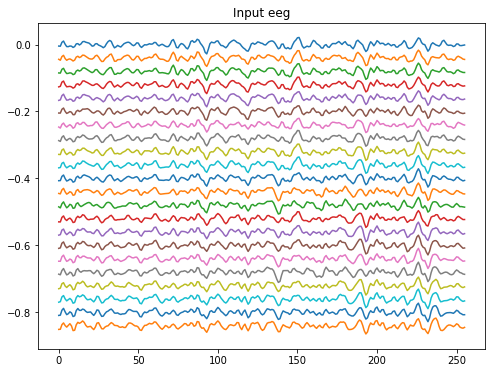

In [ ]:
# plot input
plt.figure(figsize = (8,6))
delta = 0.04
for i in range(C):
  plt.plot(x[i,:] - delta*i);
plt.title('Input eeg');

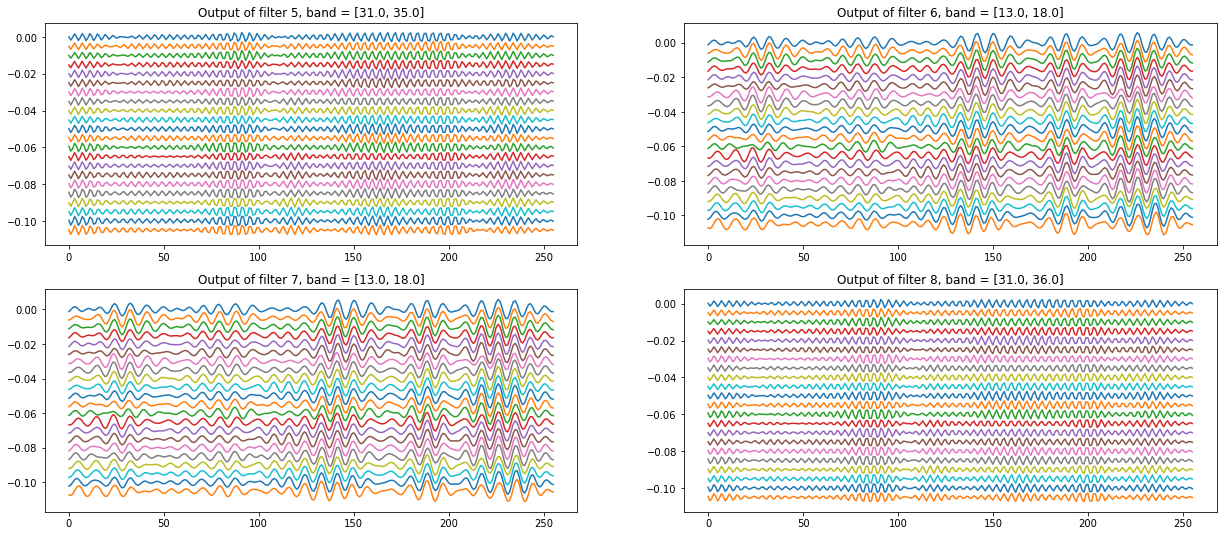

In [ ]:
# Plot output of the last 4 filters

delta = 0.005
plt.figure(figsize = (21,9))
for i in range(4):
  ax = plt.subplot(2,2,i+1)
  for j in range(C):
    plt.plot(out[j,:,i+4] - delta*j);
  ax.title.set_text('Output of filter {}, band = [{}, {}]' .format(i+5, np.round_(f1[i+4]*fs), np.round_(f2[i+4]*fs)))

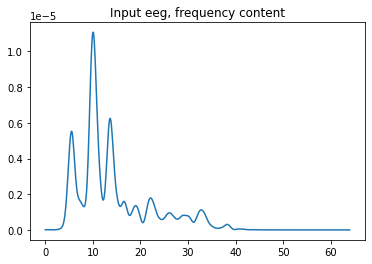

In [ ]:
f,pxx = signal.welch(x, fs = 128, nperseg = 256/2, nfft = 10*fs)
plt.plot(f,np.mean(pxx,0));
plt.title('Input eeg, frequency content');

In [ ]:
np.round(f1[i+4]*fs,1), np.round(f2[2+4]*fs,1)

(31.3, 17.6)

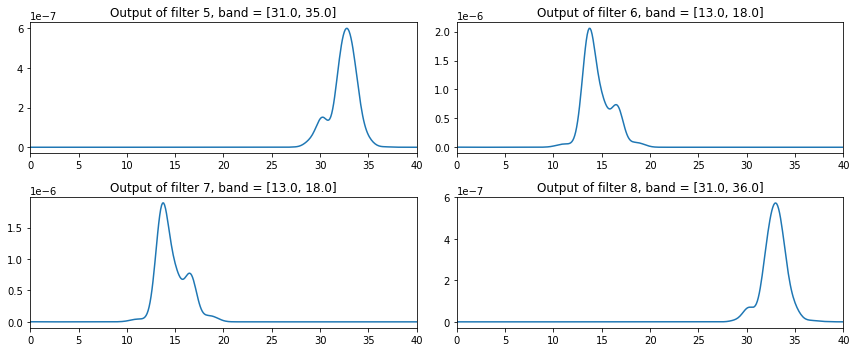

In [ ]:
win = 5*fs
plt.figure(figsize = (12,5))

for i in range(4):
  f, pxx = signal.welch(out[:,:,i+4], fs = 128, nperseg = 256/2, nfft = 2*win)
  pxx = np.mean(pxx,0) # mean psd across channels
  ax = plt.subplot(2,2,i+1); 
  ax.plot(f, pxx)
  plt.xlim((0,40))
  ax.title.set_text('Output of filter {}, band = [{}, {}]' .format(i+5, np.round(f1[i+4]*fs), np.round(f2[i+4]*fs)))
plt.tight_layout()
plt.show()

The filters work, returning different band-passed versions of the input

### Creating the class 

In [2]:
class SincConv2D(Layer):

    def __init__(
            self,
            N_filt,
            Filt_dim,
            fs,
            padding="SAME",
            **kwargs):
        self.N_filt = N_filt
        self.Filt_dim = Filt_dim
        self.fs = fs
        self.padding = padding

        super(SincConv2D, self).__init__(**kwargs)

    def build(self, input_shape):
        # The filters are trainable parameters.
        self.filt_b1 = self.add_weight(
            name='filt_b1',
            shape=(self.N_filt, 1),
            initializer='uniform',
            trainable=True)
        self.filt_band = self.add_weight(
            name='filt_band',
            shape=(self.N_filt, 1),
            initializer='uniform',
            trainable=True)

        low_freq = 4
        high_freq = 38

        # Random initialization between low_freq and high_freq
        low_hz = np.expand_dims(np.random.uniform(low_freq, high_freq, self.N_filt), axis = -1)

        hz_points = np.linspace(low_freq, high_freq, self.N_filt+1)
        band_hz = np.expand_dims(np.diff(hz_points), axis = -1)

        t_right = tf.constant(tf.linspace(1.0, (self.Filt_dim - 1) / 2, int((self.Filt_dim - 1) / 2)) / self.fs, tf.float32)
        self.T_Right = tf.tile(tf.expand_dims(t_right, axis=0), (self.N_filt, 1))

        n = tf.linspace(0, self.Filt_dim - 1, self.Filt_dim)
        window = 0.54 - 0.46 * tf.cos(2 * math.pi * n / self.Filt_dim)
        window = tf.cast(window, tf.float32)
        self.Window = tf.tile(tf.expand_dims(window, axis=0), (self.N_filt, 1))

        # This sets the weights of the layer (filt_b1 and filt_band) from a list of NumPy arrays 
        self.set_weights([low_hz/fs, band_hz/fs]) 

        super(SincConv2D, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x, **kwargs):
        
        low_freq = 4
        high_freq = 38
        # min_band = 5
        
        # Get lower and upper cutoff frequencies of the filters.
        filt_beg_freq = tf.abs(self.filt_b1)   # lower cutoff frequency

        # The upper cutoff is imposed to be always greater than the lower cutoff by filt_band
        # filt_band is a learnable parameter!! --> Instead of learning the upper cutoff I learn the pass bandwidth
        filt_end_freq = filt_beg_freq + tf.abs(self.filt_band)# + min_band/self.fs # upper cutoff frequency
        
        low_pass1 = self.low_pass_(filt_beg_freq*fs)
        low_pass2 = self.low_pass_(filt_end_freq*fs)
        band_pass = (low_pass2 - low_pass1)
        band_pass = band_pass / tf.reduce_max(band_pass, axis=1, keepdims=True)
        windowed_band_pass = band_pass * self.Window
        
        filters = tf.transpose(windowed_band_pass)
        filters = tf.reshape(filters, (1, self.Filt_dim, 1, self.N_filt))

        # Do the convolution.
        out = tf.nn.conv2d(
            x,
            filters=filters,
            strides = 1,
            padding=self.padding
        )

        return out


    def low_pass_(self, fc):
        y_right = tf.sin(math.pi * 2*fc*self.T_Right) / (math.pi * 2*fc*self.T_Right)
        y_left = tf.reverse(y_right, [1])
        y = tf.concat([y_left, tf.ones((self.N_filt, 1)), y_right], axis=1)
        return 2*fc*y

    def compute_output_shape(self, input_shape):
        new_size = conv_utils.conv_output_length(
            input_shape[2],
            self.kernel_size,
            padding="same",
            stride=1)
        return (input_shape[:2]) + (new_size,) + (self.N_filt,)

### Incorporating the sinc layer in EEGNet

In [3]:
fname = '/content/drive/MyDrive/BCI_MI_data/dataset_BCI_IV2a/sub-008.mat'
data = loadmat(fname, struct_as_record = True)
data.keys()

X = data['x_train'].transpose([2,1,0])
x_test = data['x_test'].transpose([2,1,0])
y = data['y_train'].squeeze()
y_test = data['y_test'].squeeze()
channels = data['channels']
fs = data['sf'].squeeze()

X = X*1000 # scale by 1000 due to scaling sensitivity in deep learning
x_test = x_test*1000
n_ex, C, T = X.shape

In [4]:
def SincEEGNet(nb_classes, C, T, 
             dropoutRate = 0.5, kernLength = 32, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (C, T, 1))

    ##################################################################
    block1       = SincConv2D(N_filt=F1, Filt_dim=kernLength, fs = 128,
                                   input_shape = (C, T, 1))(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D(kernel_size=(C, 1), use_bias = False, # n_filt == input_depth
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(filters=F2 , kernel_size=(1, 16), 
                                   # filters is the num of 1x1 conv filters,
                                   #  kernel_size is the size of the depthwise conv kernel
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [5]:
def SincShallowNet(nb_classes, C, T, 
             dropoutRate = 0.5, kernLength = 32, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (C, T, 1))

    ##################################################################
    block1       = SincConv2D(N_filt=F1, Filt_dim=kernLength, fs = 128,
                                   input_shape = (C, T, 1))(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D(kernel_size=(C, 1), use_bias = False, # n_filt == input_depth
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 109), 23)(block1)
    block1       = dropoutType(dropoutRate)(block1)
        
    flatten      = Flatten(name = 'flatten')(block1)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

sum = SincShallowNet(nb_classes = 4, C = C, T = T, 
              dropoutRate = 0.25, kernLength = 33, F1 = 32, D = 2, F2 = 16, 
              dropoutType = 'Dropout')
sum.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 22, 256, 1)]      0         
                                                                 
 sinc_conv2d_1 (SincConv2D)  (None, 22, 256, 32)       64        
                                                                 
 batch_normalization_2 (Batc  (None, 22, 256, 32)      128       
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 1, 256, 64)       1408      
 seConv2D)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 1, 256, 64)       256       
 hNormalization)                                                 
                                                           

Visualizing the initialized frequencies of the sinc layer

(array([[0.27724168, 0.18107262, 0.15726192, 0.06222421, 0.12425918,
         0.18958573, 0.25980657, 0.10101028, 0.2356924 , 0.23139226,
         0.21783626, 0.04792759, 0.05724765, 0.14394349, 0.21223089,
         0.17651948, 0.13163762, 0.21984786, 0.23863958, 0.16562313,
         0.09488814, 0.14517224, 0.22218111, 0.258609  , 0.26786372,
         0.13705505, 0.26311055, 0.26443017, 0.18331334, 0.16967903,
         0.08342682, 0.14811626]], dtype=float32),
 array([[0.28554246, 0.1893734 , 0.1655627 , 0.07052499, 0.13255996,
         0.19788651, 0.26810735, 0.10931106, 0.24399318, 0.23969305,
         0.22613704, 0.05622837, 0.06554843, 0.15224427, 0.22053167,
         0.18482026, 0.1399384 , 0.22814864, 0.24694036, 0.17392391,
         0.10318892, 0.15347302, 0.2304819 , 0.26690978, 0.2761645 ,
         0.14535584, 0.27141133, 0.27273095, 0.19161412, 0.17797981,
         0.0917276 , 0.15641704]], dtype=float32))

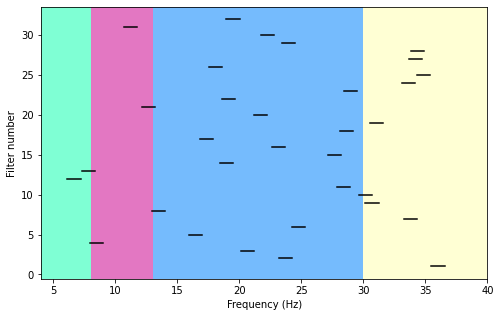

In [5]:
mod = SincEEGNet(nb_classes = 4, C = C, T = T, 
               dropoutRate = 0.25, kernLength = 33, F1 = 32, D = 2, F2 = 16, 
               dropoutType = 'Dropout')
[f1_init, band] = mod.layers[1].get_weights()
f2_init = f1_init+band
plt.figure(figsize = (8,5))
N_filt = f1_init.shape[0]
for j in range(N_filt):
  plt.plot([f1_init[j]*fs, f2_init[j]*fs], [j+1, j+1], 'k')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Filter number')
  plt.xlim([4, 40])
  plt.axvspan(4, 8, color = 'aquamarine')
  plt.axvspan(8, 13, color = 'tab:pink')
  plt.axvspan(13, 30, color = 'xkcd:sky blue')
  plt.axvspan(30, 40, color = 'xkcd:eggshell')

np.transpose(f1_init), np.transpose(f2_init)

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
kf = StratifiedKFold(5, shuffle=True, random_state=42) 

In [7]:
oos_y = []
oos_pred = []

accuracies = []

models = []

fold = 0
for train, val in kf.split(X,y):  
    
    print(f"Fold #{fold}")
        
    x_train = X[train]
    y_train = y[train]
    x_val = X[val]
    y_val = y[val]

    x_train = x_train.reshape(x_train.shape[0], C, T, 1)
    x_val = x_val.reshape(x_val.shape[0], C, T, 1)

    y_train = np_utils.to_categorical(y_train)
    y_val = np_utils.to_categorical(y_val)
    
    model = SincShallowNet(nb_classes = 4, C = C, T = T, 
              dropoutRate = 0.25, kernLength = 33, F1 = 32, D = 2, F2 = 16, 
              dropoutType = 'Dropout')
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

    #callback = EarlyStopping(monitor = 'val_accuracy', patience = 0)

    fittedModel = model.fit(x_train, y_train, batch_size = 32, epochs = 200,
                            validation_data=(x_val, y_val))#, callbacks=[callback])
    
    probs = model.predict(x_val)
    pred = probs.argmax(axis = -1)  
    
    oos_y.append(y_val)
    # raw probabilities to chosen class (highest probability) 
    oos_pred.append(pred)  

    # Measure this fold's accuracy
    y_compare = np.argmax(y_val,axis=-1) # For accuracy calculation
    score = accuracy_score(y_compare, pred)

    accuracies.append(max(fittedModel.history['val_accuracy']))
    models.append(model)
    fold = fold + 1
    print(f"Fold score (accuracy): {score}")

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=-1) # For accuracy calculation

score = accuracy_score(oos_y_compare, oos_pred)
print(f"Final score (accuracy): {score}")    
    
# Write the cross-validated prediction
#oos_y = pd.DataFrame(oos_y)
#oos_pred = pd.DataFrame(oos_pred)
#oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
#oosDF.to_csv(filename_write,index=False)

Fold #0


NameError: ignored

In [8]:
accuracies = np.array(accuracies)

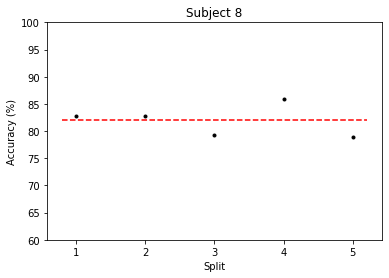

In [9]:
plt.plot(np.linspace(1,5,5),accuracies*100, 'k.')
plt.hlines(np.mean(accuracies)*100, xmin = 0.8, xmax = 5.2, colors = 'r', linestyles='dashed')
plt.ylim(60, 100)
plt.ylabel('Accuracy (%)')
plt.xlabel('Split')
plt.title('Subject 8');# + conf_sub);

In [9]:
def low_pass(fc, t_right):
    y_right = tf.sin(math.pi * 2*fc*t_right) / (math.pi * 2*fc*t_right)
    y_left = tf.reverse(y_right, [1])
    y = tf.concat([y_left, tf.ones((N_filt, 1)), y_right], axis=1)
    return 2*fc*y

In [ ]:
N_filt = 8
low_freq = 4
high_freq = 38
Filt_dim = 51

[f1, band] = models[1].layers[1].get_weights()
f2 = f1+band

t_right = tf.constant(tf.linspace(1.0, (Filt_dim - 1) / 2, int((Filt_dim - 1) / 2)) / fs, tf.float32)
T_Right = tf.tile(tf.expand_dims(t_right, axis=0), (N_filt, 1))

n = tf.linspace(0, Filt_dim - 1, Filt_dim)
window = 0.54 - 0.46 * tf.cos(2 * math.pi * n / Filt_dim)
window = tf.cast(window, tf.float32)
Window = tf.tile(tf.expand_dims(window, axis=0), (N_filt, 1))


low_pass1 = low_pass(f1*fs, T_Right)
low_pass2 = low_pass(f2*fs, T_Right)
band_pass = (low_pass2 - low_pass1)
band_pass = band_pass / tf.reduce_max(band_pass, axis=1, keepdims=True)
windowed_band_pass = band_pass * window

filters = tf.transpose(windowed_band_pass)
filters = tf.reshape(filters, (1, Filt_dim, 1, N_filt))
plt.figure(figsize=(14,9))

for i in range(N_filt):
    ax = plt.subplot(4, 2, i+1)
    f, H = signal.freqz(windowed_band_pass[i,:], fs = 128)
    ax.plot(f, np.abs(H))
    plt.xlabel('Frequency (Hz)')
    plt.xlim([0, 45])
    ax.title.set_text('Filter {}' .format(i+1))
    ax.axvline(f1[i]*fs, c = 'r', ls = '--', lw = 0.8)
    ax.axvline(f2[i]*fs, c = 'r', ls = '--', lw = 0.8)
plt.tight_layout()
plt.show()

In [ ]:
for i in range(5):
  model = model[i]
  ax = plt.subplot(5, 1, i+1)
  [f1, band] = model.layers[1].get_weights()
  f2 = f1+band
  for i in range(N_filt):
    

In [11]:
model

In [ ]:
plt.figure(figsize = (21,5))
for i in range(5):
  model = models[i]
  [f1, band] = model.layers[1].get_weights()
  f2 = f1+band
  ax = plt.subplot(1, 5, i+1)
  for j in range(N_filt):
    plt.plot([f1[j]*fs, f2[j]*fs], [j+1, j+1], 'k')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Filter number')

In [ ]:
final_model = SincEEGNet(nb_classes = 4, C = C, T = T, 
               dropoutRate = 0.25, kernLength = 33, F1 = 32, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(np.transpose(final_model.layers[1].get_weights())))
    
final_model.compile(loss='categorical_crossentropy', optimizer='adam', 
          metrics = ['accuracy'])

#callback = EarlyStopping(monitor = 'val_accuracy', patience = 0)

X = X.reshape(X.shape[0], C, T, 1)
y = np_utils.to_categorical(y)

fittedModel = final_model.fit(X, y, batch_size = 32, epochs = 200, verbose = 0, callbacks = [print_weights])

In [7]:
probs       = final_model.predict(x_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == y_test)
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.732639 


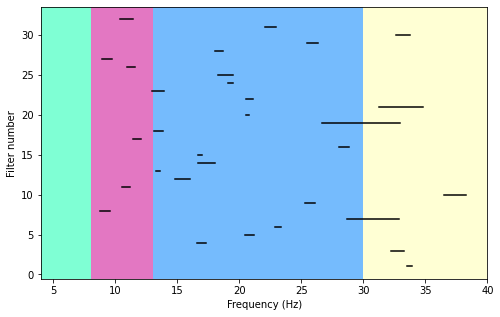

In [8]:
plt.figure(figsize = (8,5))
[f1, band] = final_model.layers[1].get_weights()
f2 = f1+band
N_filt = f1.shape[0]
for j in range(N_filt):
  plt.plot([f1[j]*fs, f2[j]*fs], [j+1, j+1], 'k')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Filter number')
  plt.xlim([4, 40])
  plt.axvspan(4, 8, color = 'aquamarine')
  plt.axvspan(8, 13, color = 'tab:pink')
  plt.axvspan(13, 30, color = 'xkcd:sky blue')
  plt.axvspan(30, 40, color = 'xkcd:eggshell')

In [ ]:
[f1, band] = final_model.layers[1].get_weights()
f2 = f1+band
abs(f1*fs-f1_init*fs), abs(f2*fs - f2_init*fs)